(tutorial-atomstracker)=
# Using AtomsTracker

Here we show how to use `AtomsTracker` to automatically record operations performed on `ase.Atoms`

Installing AiiDA takes a few extra steps and require setting up an database normally (see [here](https://aiida.readthedocs.io/projects/aiida-core/en/latest/intro/get_started.html)).   
Here, for demostration only, we use a temporay profile with `SqliteTempBackend`.

In [1]:
from aiida import load_profile, engine, orm, plugins
from aiida.manage.configuration import get_config
from aiida.storage.sqlite_temp import SqliteTempBackend

%load_ext aiida

profile = load_profile(
    SqliteTempBackend.create_profile(
        'myprofile',
        options={
            'warnings.development_version': False,
            'runner.poll.interval': 1
        },
        debug=False
    ),
    allow_switch=True
)
config = get_config()
config.add_profile(profile)
config.set_default_profile(profile.name)
profile

Profile<uuid='66a7e17bb1e3482b80e193ea2f09c42f' name='myprofile'>

In [2]:
from aiida_atoms import AtomsTracker
from ase.build import bulk

The `ase.Atoms` object models a atomic structure can be used in various ways. It is the centre piece to the `ase` ecosystem and used for constructing structure, data analysis and also calculations themselves.
Here, we focus the first use case - using `ase.Atoms` for constructing input structures used in various materials modelling workflows.
A common pattern is to start from a bulk structure, constructed manually or loaded from a online database (such as ICSD), and perform certain operations before it is used as inputs for first-principles calculations.

In this example, we start with a bulk diamond structure and create defect supercell.
To load the diamond structure:

In [3]:
c2 = bulk("C")

Creating a supercell can be done with the `.repeat` method of a `ase.Atoms` object:

In [4]:
supercell = c2.repeat((3,3,3))

Note that `.repeat` is an out-of0place operation, e.g. a new `ase.Atoms` object is created

In [5]:
print(supercell)

Atoms(symbols='C54', pbc=True, cell=[[0.0, 5.3549999999999995, 5.3549999999999995], [5.3549999999999995, 0.0, 5.3549999999999995], [5.3549999999999995, 5.3549999999999995, 0.0]])


A vacancy can be created by removing a single atom

In [6]:
supercell.pop(0)
print(supercell)

Atoms(symbols='C53', pbc=True, cell=[[0.0, 5.3549999999999995, 5.3549999999999995], [5.3549999999999995, 0.0, 5.3549999999999995], [5.3549999999999995, 5.3549999999999995, 0.0]])


Now our supercell has only 53 atoms, we write it to the disk in the [POSCAR](https://www.vasp.at/wiki/index.php/POSCAR) format.

In [7]:
supercell.write("C_Vac_c.vasp")

The structure can be read into a different python session for further operation or used for calculation.

In [8]:
import ase.io
supercell_loaded = ase.io.read("C_Vac_c.vasp")

## Tracking operations performed on `ase.Atoms`

The file `C_Vac_c.vasp` itself does not contain any history about how it was made, e.g  which structure was used as the bulk and which atom was removed, especially with more complex structures.

Here comes the `AtomsTracker` to rescue! As the name suggests, it tracks the underlying `ase.Atoms` object as long as the methods called as those of the tracked object.

:::{seealso} Implementation
:class: dropdown

The tracker is implemented using the [@calcfunction](https://aiida.readthedocs.io/projects/aiida-core/en/latest/topics/calculations/concepts.html?#calculation-functions) api in AiiDA core.
The actual method calls `ase.Atoms` are done within a function wrapped by the `@calcfunction` decorator.
:::

In [9]:
tracker = AtomsTracker(c2)
tracker.label = "C2 Primitive"
defect_cell = tracker.repeat((3,3,3))
defect_cell.pop(0)
defect_cell.rattle(stdev=0.05, seed=11)
defect_cell.label = "C2 Rattled supercell"

now both `tracker` and `supercell` are `AtomsTracker` objects:

In [10]:
print(tracker)
print(defect_cell)

AtomsTracker(Atoms(symbols='C2', pbc=True, cell=[[0.0, 1.785, 1.785], [1.785, 0.0, 1.785], [1.785, 1.785, 0.0]]), <StructureData: uuid: 6b244479-a24c-4ae6-a8a3-647e757b322f (pk: 2)>)
AtomsTracker(Atoms(symbols='C53', pbc=True, cell=[[0.0, 5.3549999999999995, 5.3549999999999995], [5.3549999999999995, 0.0, 5.3549999999999995], [5.3549999999999995, 5.3549999999999995, 0.0]], masses=...), <StructureData: uuid: 1c516cdf-95ca-4c4b-ae1e-a684c0206572 (pk: 11)>)


An `AtomsTracker` is just an `ase.Atoms` object plus an `aiida.orm.StructureData` with methods of `ase.Atoms` attached.

In [11]:
print(tracker.atoms)

print(tracker.node.__repr__())

Atoms(symbols='C2', pbc=True, cell=[[0.0, 1.785, 1.785], [1.785, 0.0, 1.785], [1.785, 1.785, 0.0]])
<StructureData: uuid: 6b244479-a24c-4ae6-a8a3-647e757b322f (pk: 2)>


In [12]:
print(defect_cell.atoms)

print(defect_cell.node.__repr__())

Atoms(symbols='C53', pbc=True, cell=[[0.0, 5.3549999999999995, 5.3549999999999995], [5.3549999999999995, 0.0, 5.3549999999999995], [5.3549999999999995, 5.3549999999999995, 0.0]], masses=...)
<StructureData: uuid: 1c516cdf-95ca-4c4b-ae1e-a684c0206572 (pk: 11)>


Now the `supercell` includes the history show how it was made

:::{danger}
Do not call the method of the underlying `ase.Atoms` object directly - this will cause the tracker to lose track of the atom, resulting in incorrect provenance.
:::

In [13]:
calc_pop = defect_cell.node.base.links.get_incoming().one()
print(calc_pop)

LinkTriple(node=<CalcFunctionNode: uuid: 4e5b3684-4fd7-4d29-be89-2ce14c2e2b64 (pk: 10) (ase.atoms.rattle)>, link_type=<LinkType.CREATE: 'create'>, link_label='result')


The [`LinkTriple`](https://aiida.readthedocs.io/projects/aiida-core/en/latest/howto/query.html?incoming-and-outgoing-links) object is an object to represent a link between two nodes. Here, one is the output strucutre `supercell.node` and the other is a `Calculation` that create the output.

We can also check what are the inputs used in this calculation:

In [14]:
calc_func = calc_pop.node
calc_func.base.links.get_incoming().all()

[LinkTriple(node=<Float: uuid: 33bb8017-871e-4e8a-9b01-41ac4b3c8170 (pk: 8) value: 0.05>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='stdev'),
 LinkTriple(node=<Int: uuid: 704aa0c5-85cb-4ffa-b052-5f8296575c36 (pk: 9) value: 11>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='seed'),
 LinkTriple(node=<StructureData: uuid: 002e83da-0bd1-4057-b127-7cbfc87a909e (pk: 7)>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='node')]

## Visualising provenance

AiiDA provides some tools to visualise the provenance.

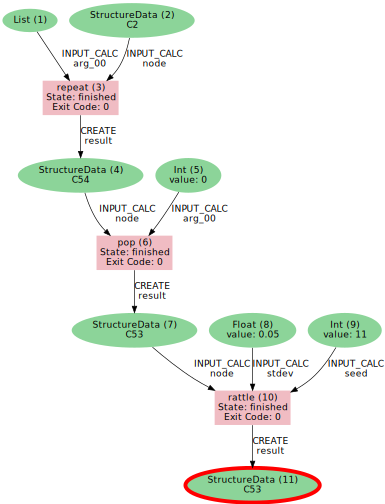

In [15]:
from aiida.tools.visualization import Graph
def view_provenance(node, **kwargs):
    graph = Graph(graph_attr={"size":"7.0"})
    graph.recurse_ancestors(node, annotate_links="both")
    return graph.graphviz
def view_descendants(node, **kwargs):
    graph = Graph(graph_attr={"size":"7.0"})
    graph.recurse_descendants(node, annotate_links="both", include_process_inputs=True)
    return graph.graphviz
view_provenance(defect_cell.node)

:::{note}
You may will need to install `graphviz` to be able to render the graph in the notebook.

This can be down using `conda install -c conda-forge graphviz`.
:::

Great, we now have a full history of how our defect supercell is created.  
`note`{The links are labeled with the names of the keyword arguments, but the positional arguments are labeld with *arg_00*.}

Now let'ts create a few more defect structures, note the `pop` operation does an in-place mutation of the `supercell`, hence we have lost access to our pristine supercell.
With the tracker, all intermediate results are stored in the database.
This allow us to load the pristine supercell back without problem.

In [16]:
perfect_supercell = AtomsTracker(orm.load_node(4))
defect2 = AtomsTracker(perfect_supercell)
defect2.pop(1)

Atom('C', [0.8925, 0.8925, 0.8925], mass=12.011)

Note that `.pop` returns an `ase.Atom` object, and the tracker retains this behaviour.

For out-of-place operations, such as `repeat` or `sort`, returns a tracker tracking the new `ase.Atoms` object created.

In [17]:
sorted_defect2 = defect2.sort()
sorted_defect2 is defect2

False

We can also check what the descendants of a given node are, as we used an bulk diamond structure as the starting point, all structures created are descendants of it.

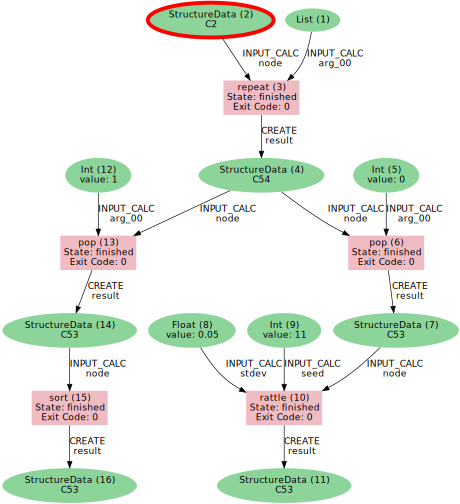

In [18]:
view_descendants(tracker.node)

## Shortcuts

The `AtomsTracker` also provides some shortcuts to the attributes of the underlying `StructureData` object.
The `AtomsTracker.base` is equivalent to `AtomsTracker.node.base`, for example

In [19]:
tracker.base.links.get_outgoing().all()

[LinkTriple(node=<CalcFunctionNode: uuid: c6deb1bf-1e93-42e6-bb4f-40ce02ebeefb (pk: 3) (ase.atoms.repeat)>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='node')]

is the same as

In [20]:
tracker.node.base.links.get_outgoing().all()

[LinkTriple(node=<CalcFunctionNode: uuid: c6deb1bf-1e93-42e6-bb4f-40ce02ebeefb (pk: 3) (ase.atoms.repeat)>, link_type=<LinkType.INPUT_CALC: 'input_calc'>, link_label='node')]

The `label` and `descriptions` of the underlying `node` also have shortcut.

In [21]:
tracker.label = "My defect node"
tracker.description = "An initial C2 primitive cell"

print(tracker.node.label)
print(tracker.node.description)

My defect node
An initial C2 primitive cell


## Using the data later

The `node` attribute of the tracker is stored in AiiDA's database. There are two ways to identify a `node`:

id
: An integer that is unique within the database, but may change is the data is exported and imported to other database afterwards.

uuid
: A long string that is unique and will remain constant when imported/exported.

The `uuid` is the preferred way of referring to the data as it is always stable.
Just like `label` and `description`, there are also shortcuts.

In [22]:
print(defect2.id)
print(defect2.uuid)

14
74de9f06-5480-4394-8b10-91cbba62ab5b


We can load the defect from the database again with, this works in a different python session as long as you have the correct `uuid`.

In [23]:
defect2_reloaded = AtomsTracker(orm.load_node(defect2.uuid))
defect2_reloaded

AtomsTracker(Atoms(symbols='C53', pbc=True, cell=[[0.0, 5.355, 5.355], [5.355, 0.0, 5.355], [5.355, 5.355, 0.0]], masses=...), <StructureData: uuid: 74de9f06-5480-4394-8b10-91cbba62ab5b (pk: 14)>)

:::{tip}

One can also load data with first few characters of the `uuid` or the label of the node, as long as the value is unique in the database.

```python3
defect2_reloaded = AtomsTracker(orm.load_node("My defect node"))
```

should also work.
:::